In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']= '3'

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers
from tensorflow.keras import losses
import re
import string
import matplotlib.pyplot as plt


In [2]:
# Select your favourite number for the random seed
seed = 555

#sets the global random seed for numpy
np.random.seed(seed)

#sets the global random seed for tensorflow
tf.random.set_seed(seed)



In [3]:
data_dir = './data/aclImdb'

In [4]:
raw_training_set = tf.keras.utils.text_dataset_from_directory(
                    f'{data_dir}/train',
                    labels = 'inferred',
                    label_mode= 'int',
                    batch_size = 32,
                    validation_split=0.2,
                    subset = 'training',
                    seed=seed )

raw_validation_set = tf.keras.utils.text_dataset_from_directory(
                    f'{data_dir}/train',
                    labels = 'inferred',
                    label_mode = 'int',
                    batch_size = 32,
                    validation_split= 0.2,
                    subset = 'validation',
                    seed=seed )

raw_test_set = tf.keras.utils.text_dataset_from_directory(
                    f'{data_dir}/test', 
                    labels ='inferred',
                    label_mode='int',
                    batch_size=32)

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Found 5000 files belonging to 2 classes.


In [5]:
print(f"Label 0 corresponds to {raw_training_set.class_names[0]}")
print(f"Label 1 corresponds to {raw_training_set.class_names[1]}")

Label 0 corresponds to neg
Label 1 corresponds to pos


In [6]:
# for text_batch , label_batch in raw_training_set.take(1):
#     for i in range(3):
#         print(f'Review:\n {text_batch.numpy()[i]}')
#         print(f'Label:{label_batch.numpy()[i]}\n')

## 3. Prepare the Data

In [7]:
max_features = 10000

def custom_standardization(input_data):
    
    lowercase = tf.strings.lower(input_data)
    
    stripped_html = tf.strings.regex_replace(lowercase , '<br />', ' ')
    
    replaced = tf.strings.regex_replace(stripped_html, 
                                        '[%s]'%re.escape(string.punctuation),
                                        '' )
    return replaced


vectorize_layer = layers.TextVectorization(
                  standardize= custom_standardization,
                  max_tokens = max_features,
                  output_mode='int',
                  output_sequence_length=250 )

In [8]:
input_data = "Harshada' htpps://6761546.html Patke is here"
custom_standardization(input_data)

<tf.Tensor: shape=(), dtype=string, numpy=b'harshada htpps6761546html patke is here'>

In [9]:
train_text = raw_training_set.map(lambda x, y:x)
vectorize_layer.adapt(train_text)

# Print out the vocabulary size
print(f"Vocabulary size: {len(vectorize_layer.get_vocabulary())}")

Vocabulary size: 10000


In [10]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

text_batch, label_batch = next(iter(raw_training_set))
first_review , first_label = text_batch[0], label_batch[0]

# Show the raw data
print(f"Review:\n{first_review}")
print(f"\nLabel: {raw_training_set.class_names[first_label]}")
# Show the vectorized data
print(f"\nVectorized review\n{vectorize_text(first_review, first_label)}")

Review:
b"A thematic staple of cinema since its inception is that genre involving seductive women whose wiles and means entice susceptible men not only into their arms but also into dire circumstances that typically will only result in jeopardy for the male victims, along with incertitude as to whether or not temptresses will be forced to take their medicine, and here Susan Lucci performs as a siren, although her acting chops from a primarily soap opera pedigree are inadequate to make her performance a credible one. Isabelle (Lucci), inconstant wife of venture capitalist Stewart Collins (John O'Hurley), begins a love affair merely for fun with yacht salesman Richard Davis (Philip Casnoff), simply a bagatelle for her but an earnest matter of the heart for Richard, apparently mesmerized by his lover while she takes advantage of his ardour by engaging him in a risky plot that will graduate into a scheme of murderous intent. When Davis becomes convinced that guileful Isabelle is a victim o

In [11]:
train_ds = raw_training_set.map(vectorize_text)
val_ds = raw_validation_set.map(vectorize_text)
test_ds = raw_test_set.map(vectorize_text)

In [12]:
len(train_ds), len(val_ds), len(test_ds)

(125, 32, 157)

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 4. Create a Sequential Model

In [14]:
embedding_dim =16

model_sequential = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.GlobalAvgPool1D(),
    layers.Dense(1, activation='sigmoid')
])

model_sequential.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
model_sequential.compile(loss = losses.BinaryCrossentropy(),
                            optimizer='adam',
                            metrics=['accuracy'])

In [16]:
# Define the inputs
inputs = tf.keras.Input(shape=(None,))

# Define the first layer
embedding = layers.Embedding(max_features, embedding_dim)
# Call the first layer with inputs as the parameter
x = embedding(inputs)

# Define the second layer
pooling = layers.GlobalAveragePooling1D()
# Call the first layer with the output of the previous layer as the parameter
x = pooling(x)

# Define and call in the same line. (Same thing used two lines of code above
# for other layers. You can use any option you prefer.)
outputs = layers.Dense(1, activation='sigmoid')(x)
#The two-line alternative to the one layer would be:
# dense = layers.Dense(1, activation='sigmoid')
# x = dense(x)


# Create the model
model_functional = tf.keras.Model(inputs=inputs, outputs=outputs)

# Print out the summary of the model
model_functional.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 16)          160000    
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
model_functional.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

In [18]:
# Select which model you want to use and train. the results should be the same
model = model_functional 
# model = model_sequential

In [19]:
epochs = 25

history = model.fit(
                train_ds,
                validation_data=val_ds,
                epochs = epochs,
                verbose =2)

Epoch 1/25
125/125 - 2s - loss: 0.6900 - accuracy: 0.5915 - val_loss: 0.6856 - val_accuracy: 0.7000 - 2s/epoch - 15ms/step
Epoch 2/25
125/125 - 1s - loss: 0.6776 - accuracy: 0.7427 - val_loss: 0.6708 - val_accuracy: 0.7330 - 731ms/epoch - 6ms/step
Epoch 3/25
125/125 - 1s - loss: 0.6560 - accuracy: 0.7692 - val_loss: 0.6484 - val_accuracy: 0.7500 - 679ms/epoch - 5ms/step
Epoch 4/25
125/125 - 1s - loss: 0.6265 - accuracy: 0.7805 - val_loss: 0.6215 - val_accuracy: 0.7540 - 693ms/epoch - 6ms/step
Epoch 5/25
125/125 - 1s - loss: 0.5927 - accuracy: 0.7965 - val_loss: 0.5932 - val_accuracy: 0.7700 - 674ms/epoch - 5ms/step
Epoch 6/25
125/125 - 1s - loss: 0.5578 - accuracy: 0.8180 - val_loss: 0.5653 - val_accuracy: 0.7800 - 689ms/epoch - 6ms/step
Epoch 7/25
125/125 - 1s - loss: 0.5233 - accuracy: 0.8367 - val_loss: 0.5389 - val_accuracy: 0.8000 - 725ms/epoch - 6ms/step
Epoch 8/25
125/125 - 1s - loss: 0.4902 - accuracy: 0.8560 - val_loss: 0.5143 - val_accuracy: 0.8050 - 681ms/epoch - 5ms/step
Ep

In [20]:
loss, accuracy = model.evaluate(test_ds)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

157/157 [==============================] - 1s 4ms/step - loss: 0.3644 - accuracy: 0.8450
Loss: 0.36438503861427307
Accuracy: 0.8450000286102295


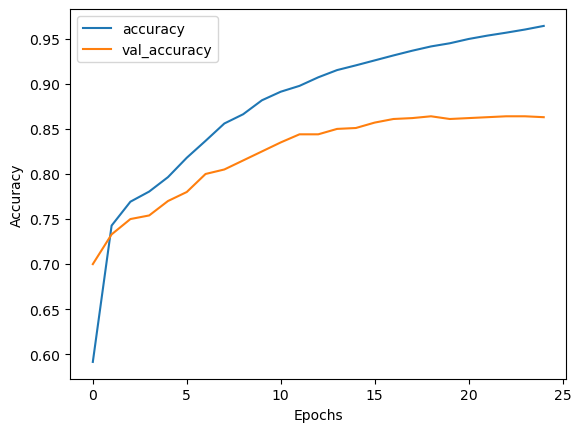

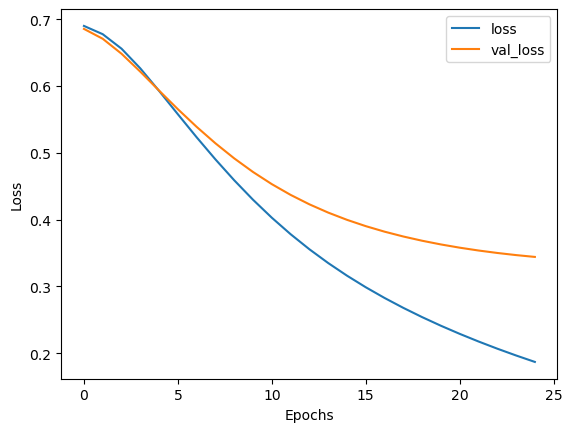

In [21]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric.title())
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

In [22]:
###Predic on own data

export_model = tf.keras.Sequential([vectorize_layer,
                                    model])

export_model.compile(loss = losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics= ['accuracy'])

In [23]:
examples = ['this movie was very, very good',
            'quite ok', 
            'the movie was not bad',
            'bad',
            'negative disappointed bad scary',
            'this movie was stupid']

results = export_model.predict(examples, verbose=False)

In [24]:
for result, example in zip(results, examples):
    print(f'Result: {result[0]:.3f},   Label: {int(np.round(result[0]))},   Review: {example}')

Result: 0.592,   Label: 1,   Review: this movie was very, very good
Result: 0.493,   Label: 0,   Review: quite ok
Result: 0.392,   Label: 0,   Review: the movie was not bad
Result: 0.442,   Label: 0,   Review: bad
Result: 0.371,   Label: 0,   Review: negative disappointed bad scary
Result: 0.401,   Label: 0,   Review: this movie was stupid


In [25]:
results

array([[0.59220886],
       [0.49254858],
       [0.39235646],
       [0.4415283 ],
       [0.37145683],
       [0.40073806]], dtype=float32)